<a href="https://colab.research.google.com/github/atarasaki/DSWP-editados/blob/main/Notebooks/2020-11-18-NB10_04__3DP_4_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b><i>3DP_4 - ANOMALY/OUTLIER DETECTION</i></b></h1></center>



# **AGENDA**:

> Consulte a **Table of contents**.

# **Melhorias da sessão**
* Mostrar junto os gráficos com a região de Anomaly Score junto com a distribuição de probabilidade das variáveis envolvidas.
* Mensagens de deprecating --> Analisar e substituir os métodos, funções deprecated;


___
# **Referências**
* [Comparing anomaly detection algorithms for outlier detection on toy datasets](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py)
* [Outlier detection with several methods](https://scikit-learn.org/0.18/auto_examples/covariance/plot_outlier_detection.html)
* [anomaly-detection-resources](https://github.com/MathMachado/anomaly-detection-resources)
* [Outlier Detection with Extended Isolation Forest](https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b)
* [Outlier Detection with Isolation Forest](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e).

___
## O que é Anomaly Detection (= Análise de Outliers)?
> Qualquer ponto/observação que é incomum quando comparado com todos os outros pontos/observações.

___
# **Machine Learning com Python (Scikit-Learn)**

![Scikit-Learn](https://github.com/MathMachado/Materials/blob/master/scikit-learn-1.png?raw=true)

___
# **Técnicas tradicionais para detecção de outliers**

## Boxplot
* $IQR = Q_{3}-Q_{1}$

![BoxPlot](https://github.com/MathMachado/Materials/blob/master/boxplot.png?raw=true)

## Z-Score
* Z-Score pode ser utilizado para detectar Outliers.
* É a diferença entre o valor e a média da amostra expressa como o número de desvios-padrão. 
* Se o escore z for menor que 2,5 ou maior que 2,5, o valor estará nos 5% do menor ou maior valor (2,5% dos valores em ambas as extremidades da distribuição). No entanto, é pratica comum utilizarmos 3 ao invés dos 2,5.

![Z_Score](https://github.com/MathMachado/Materials/blob/master/Z_Score.png?raw=true)

___
# **Hands-On**

## Carrega as Bibliotecas necessárias

In [1]:
!pip install pyod

     |████████████████████████████████| 102kB 3.9MB/s 
     |████████████████████████████████| 2.1MB 7.1MB/s 
  Created wheel for pyod: filename=pyod-0.8.4-cp36-none-any.whl size=112083 sha256=9ea7c7b243e0dd8e82b1822f475235763475a9a78368171a785478a06075dc68
  Stored in directory: /root/.cache/pip/wheels/ad/31/0a/c2d4ba2d066145c55f0cb2846e59b18d874cb59c5d9adc81cf
  Created wheel for combo: filename=combo-0.1.1-cp36-none-any.whl size=42113 sha256=69aca7684eacfb78d1e345591131ddecb2404cc6ddd55cb0cddd2585645261e2
  Stored in directory: /root/.cache/pip/wheels/55/ec/e5/a2331372c676c467e70c6646e646edf6997d5c4905b8c0f5e6
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167158 sha256=1187f8e58ac594d9a449f5b989c40e72b0ecad6b1ab1ea9dff58ea1b369b87f6
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


In [2]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest

# Scaling variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF

#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
#from pyod.models.lof import LOF
from scipy import stats

# remove warnings to keep notebook clean
import warnings
warnings.filterwarnings('ignore')

## Carrega dataframe

In [3]:
df_titanic = sns.load_dataset('titanic')
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
df_titanic.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [5]:
# Por simplicidade, vou descartando/omitindo todos os Missing Values
df_titanic = df_titanic.dropna() # Esta não é a forma adequada! Dê o devido tratamento aos Missing Values (NaN) da base de dados!
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.0,1,1,16.7000,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.0,0,0,26.5500,S,First,woman,False,C,Southampton,yes,True


In [6]:
# Normalizar as variáveis 'age' e 'fare'
df_titanic_ss = df_titanic.copy()
df_titanic_ss[['fare', 'age']] = StandardScaler().fit_transform(df_titanic_ss[['fare', 'age']])

In [7]:
# Linhas do df_titanic
df_titanic_ss.shape

(182, 15)

In [8]:
# Função para plotar o Boxplot
def boxplot_sobreviveu(df, column):
    plt.rcdefaults()
    sns.catplot(x = 'survived', y = column, kind = "box", data = df, height = 4, aspect = 1.5)
    
    # add data points to boxplot with stripplot
    sns.stripplot(x = 'survived', y = column, data = df, alpha = 0.3, jitter = 0.2, color = 'k');
    plt.show()

Esta é a visão univariada da variável 'fare':

In [9]:
df_titanic[['survived']].head()

,survived
1,1
3,1
6,0
10,1
11,1


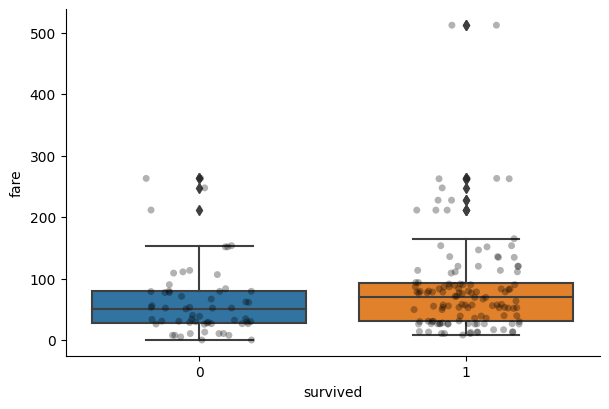

In [10]:
boxplot_sobreviveu(df_titanic, 'fare')

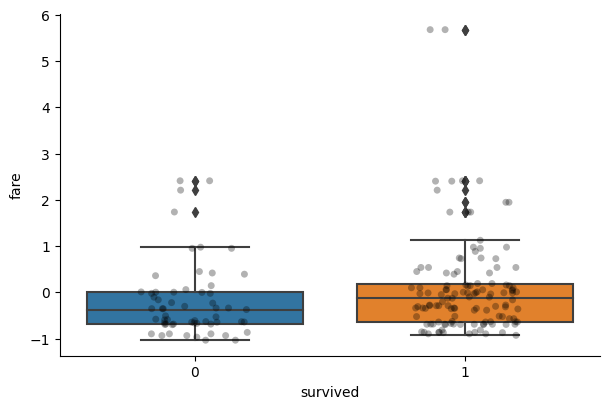

In [11]:
boxplot_sobreviveu(df_titanic_ss, 'fare')

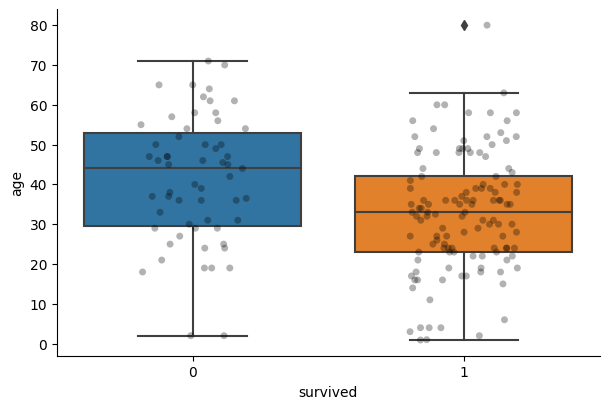

In [12]:
boxplot_sobreviveu(df_titanic, 'age')

In [13]:
# Descrever o dataframe, variável 'fare'
pd.set_option('display.float_format', lambda x: '%.3f' %x)
df_titanic_ss['fare'].describe()

count   182.000
mean      0.000
std       1.003
min      -1.035
25%      -0.645
50%      -0.287
75%       0.145
max       5.682
Name: fare, dtype: float64

## Mostrar a frequência acumulada!! É mais informativo!!!

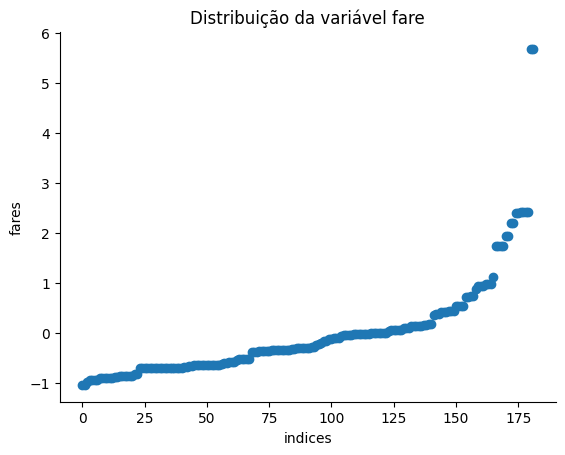

In [14]:
plt.scatter(range(df_titanic_ss.shape[0]), np.sort(df_titanic_ss['fare'].values)) # A intenção do gráfico é ordenar os valores em df_titanic['fare'] do menor valor para o maior!
plt.xlabel('indices')
plt.ylabel('fares')
plt.title("Distribuição da variável fare")

sns.despine()

Com o gráfico acima, podemos ver quais e quantos são os pontos que estão acima de $\mu + 3\sigma$ --> Se usarmos o critério do z-score, todos os pontos acima deste limiar são outliers!

 Colocar os gráficos lado a lado: df_titanic e df_titanic_ss!!

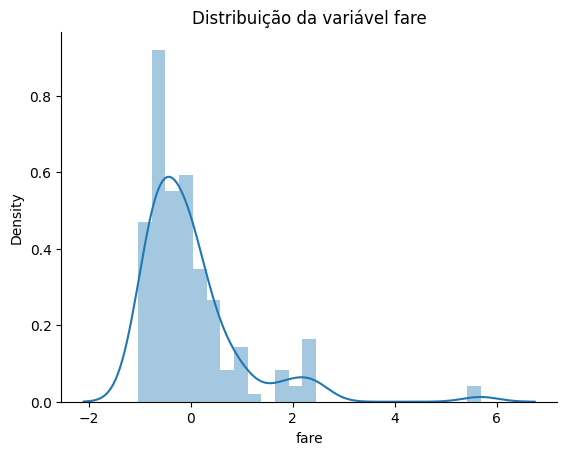

In [15]:
# Distribuição da variável 'fare' (após StandardScaler)
sns.distplot(df_titanic_ss['fare'])
plt.title("Distribuição da variável fare")
sns.despine()

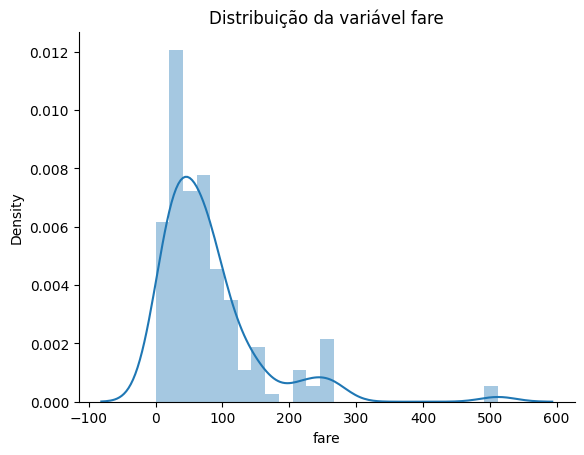

In [16]:
# Distribuição da variável 'fare' (após StandardScaler)
sns.distplot(df_titanic['fare'])
plt.title("Distribuição da variável fare")
sns.despine()

### Calcular a mediana e comparar com a média.

In [17]:
df_titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,182.000,182.000,182.000,182.000,182.000,182.000
mean,0.676,1.192,35.623,0.467,0.478,78.920
std,0.469,0.516,15.672,0.645,0.756,76.491
min,0.000,1.000,0.920,0.000,0.000,0.000
25%,0.000,1.000,24.000,0.000,0.000,29.700
50%,1.000,1.000,36.000,0.000,0.000,57.000
75%,1.000,1.000,47.750,1.000,1.000,90.000
max,1.000,3.000,80.000,3.000,4.000,512.329


___
## Kurtosis
> Kurtosis é uma medida estatística que define com que intensidade as caudas de uma distribuição diferem das caudas de uma distribuição Normal. Em outras palavras, a curtose identifica se as caudas de uma determinada distribuição contêm valores extremos.
>> A Kurtosis de uma distribuição Normal padrão é igual a 3. Portanto, se Kurtosis-3 > 0, então isso é o que chamamos de excesso de Kurtosis.
>>> **Alta Kurtosis é um indicador de que os dados possuem caudas pesadas ou outliers**.

* **Dica muito importante**: Normalize os dados antes!

___
## Skewness
> É o grau de distorção da distribuição, ou seja, mede a falta de simetria na distribuição de dados, diferenciando valores extremos em uma cauda versus na outra. Uma distribuição simétrica terá uma assimetria de 0.

![Skewness](https://github.com/MathMachado/Materials/blob/master/Skewness.png?raw=true)

Source: [Skew and Kurtosis: 2 Important Statistics terms you need to know in Data Science](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa)

### Interpretando a Skewness (Rule of Thumb)
* Se -0.5 < Skewness < 0.5: Dados razoavelmente simétricos;
* Se -1 < Skewness < -0.5: Dados moderadamente negativa;
* Se 0.5 < Skewness < 1: Dados moderadamente positiva;
* Se Skewness < -1: Dados altamente negativa;
* Se Skewness > 1: Dados altamente positiva.

> **Dica**: Normalize os dados antes!

In [18]:
# Cálculo das medidas de Skewness e Kurtosis para 'fare'
print(f"Skewness: {df_titanic_ss['fare'].skew()}")
print(f"Kurtosis: {df_titanic_ss['fare'].kurt()}")

Skewness: 2.7073683146429004
Kurtosis: 10.690697893681472


Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

In [19]:
# Distribuição da variável 'age'
df_titanic_ss['age'].describe()

count   182.000
mean      0.000
std       1.003
min      -2.221
25%      -0.744
50%       0.024
75%       0.776
max       2.839
Name: age, dtype: float64

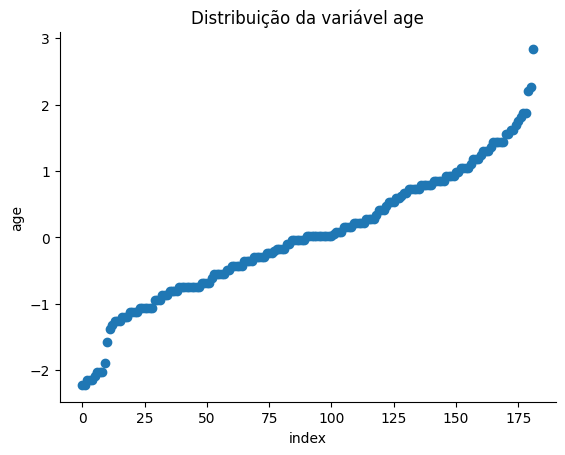

In [20]:
plt.scatter(range(df_titanic_ss.shape[0]), np.sort(df_titanic_ss['age'].values))
plt.xlabel('index')
plt.ylabel('age')
plt.title("Distribuição da variável age")
sns.despine()

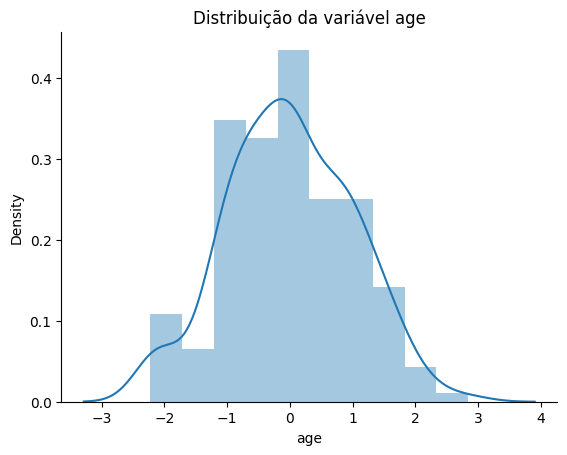

In [21]:
sns.distplot(df_titanic_ss['age'])
plt.title("Distribuição da variável age")
sns.despine()

In [22]:
# Cálculo das medidas de Skewness e Kurtosis para 'age'
print(f"Skewness: {df_titanic_ss['age'].skew()}")
print(f"Kurtosis: {df_titanic_ss['age'].kurt()}")

Skewness: 0.01841894050949496
Kurtosis: -0.2309427735598728


Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

___
## **Isolation Forest Region**
* Source: [Outlier Detection with Isolation Forest](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e)

### Anomaly Detection para 'fare'

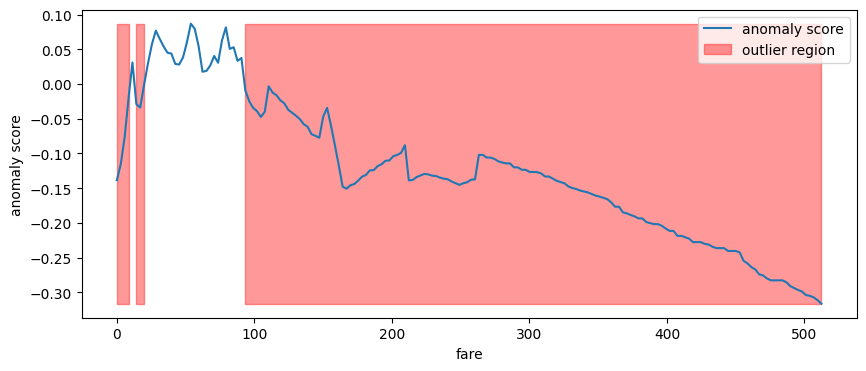

In [23]:
# Instanciamento 
isolation_forest = IsolationForest(n_estimators = 100) 

# Ajustamento (fit())
isolation_forest.fit(df_titanic['fare'].values.reshape(-1, 1))
xx = np.linspace(df_titanic['fare'].min(), df_titanic['fare'].max(), len(df_titanic)).reshape(-1, 1)

anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize = (10, 4))
plt.plot(xx, anomaly_score, label = 'anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where = outlier == -1, color = 'r', alpha = .4, label = 'outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('fare')
plt.show()

**Conclusão**: anomaly_score > 0 --> Não é outliers. Do contrário, ou seja, se anomaly_score < 0 --> Outlier.

In [24]:
# Vamos avaliar os dados do dataframe para fare > 200, por exemplo
df_titanic.loc[df_titanic['fare'] > 200].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
27,0,1,male,19.000,3,2,263.000,S,First,man,True,C,Southampton,no,False
88,1,1,female,23.000,3,2,263.000,S,First,woman,False,C,Southampton,yes,False
118,0,1,male,24.000,0,1,247.521,C,First,man,True,B,Cherbourg,no,False
299,1,1,female,50.000,0,1,247.521,C,First,woman,False,B,Cherbourg,yes,False
311,1,1,female,18.000,2,2,262.375,C,First,woman,False,B,Cherbourg,yes,False


In [25]:
# Zoom na linha 27
df_titanic.loc[27]

survived                 0
pclass                   1
sex                   male
age                 19.000
sibsp                    3
parch                    2
fare               263.000
embarked                 S
class                First
who                    man
adult_male            True
deck                     C
embark_town    Southampton
alive                   no
alone                False
Name: 27, dtype: object

A região onde os dados têm baixa probabilidade de aparecer fica no lado direito da distribuição.

### Anomaly Detection para 'age'

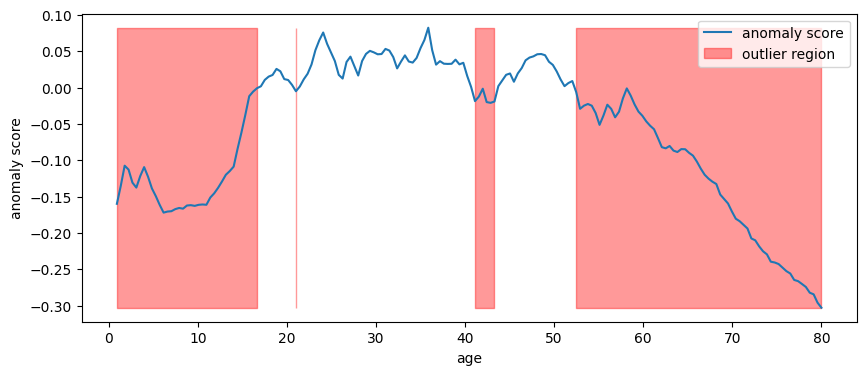

In [26]:
isolation_forest = IsolationForest(n_estimators = 100)
isolation_forest.fit(df_titanic['age'].values.reshape(-1, 1))
xx = np.linspace(df_titanic['age'].min(), df_titanic['age'].max(), len(df_titanic)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize = (10, 4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where = outlier == -1, color = 'r', alpha = .4, label = 'outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('age')
plt.show();

Observe no gráfico acima que há duas regiões em que os dados têm baixa probabilidade de aparecer: uma no lado esquerdo da distribuição, outra no lado direito da distribuição.

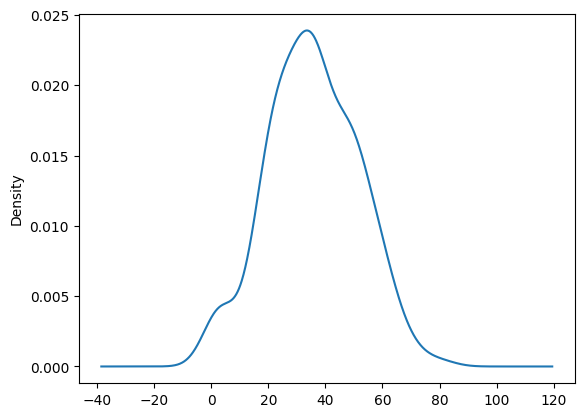

In [64]:
df_titanic['age'].plot(kind='kde')

In [66]:
df_titanic['age_cat'] = pd.cut( df_titanic['age'], bins=[0,10,20,30,40,50,60,70,80,90])
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,age_cat
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False,"(30, 40]"
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False,"(30, 40]"
6,0,1,male,54.000,0,0,51.862,S,First,man,True,E,Southampton,no,True,"(50, 60]"
10,1,3,female,4.000,1,1,16.700,S,Third,child,False,G,Southampton,yes,False,"(0, 10]"
11,1,1,female,58.000,0,0,26.550,S,First,woman,False,C,Southampton,yes,True,"(50, 60]"


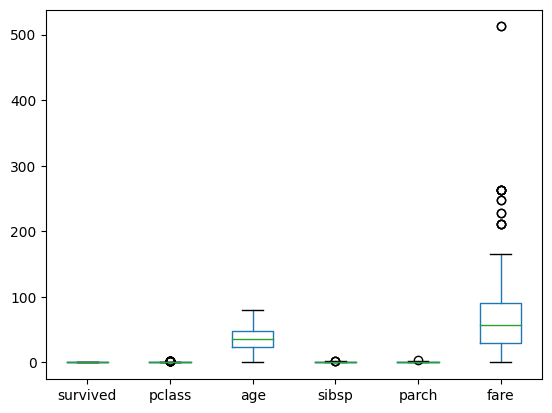

In [68]:
df_titanic.plot(kind='box')

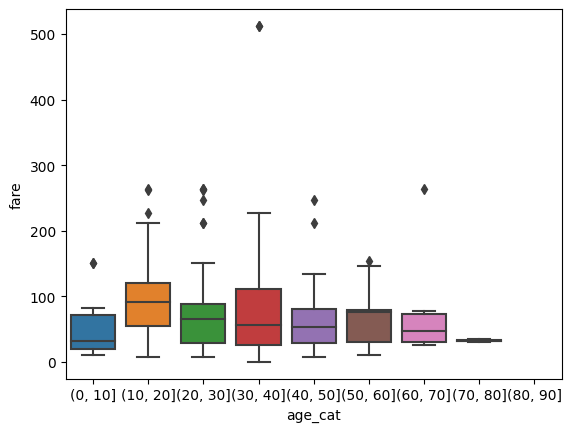

In [69]:
sns.boxplot( x='age_cat', y='fare', data=df_titanic )

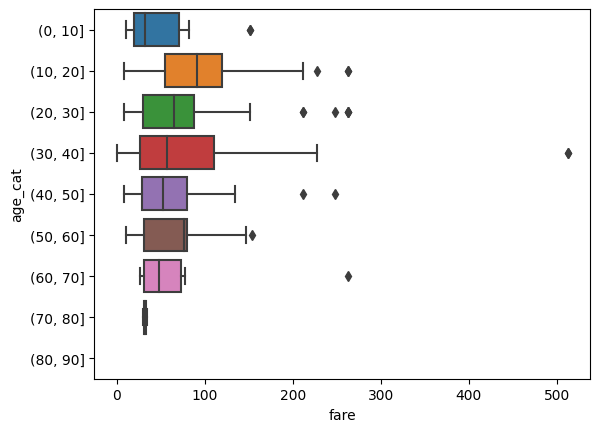

In [70]:
sns.boxplot( y='age_cat', x='fare', data=df_titanic )

In [27]:
# Avaliando os dados da cauda esquerda
df_titanic.loc[df_titanic['age'] < 15].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
10,1,3,female,4.000,1,1,16.700,S,Third,child,False,G,Southampton,yes,False
183,1,2,male,1.000,2,1,39.000,S,Second,child,False,F,Southampton,yes,False
193,1,2,male,3.000,1,1,26.000,S,Second,child,False,F,Southampton,yes,False
205,0,3,female,2.000,0,1,10.463,S,Third,child,False,G,Southampton,no,False
297,0,1,female,2.000,1,2,151.550,S,First,child,False,C,Southampton,no,False


In [28]:
# Zoom na linha 3
df_titanic.loc[10]

survived                 1
pclass                   3
sex                 female
age                  4.000
sibsp                    1
parch                    1
fare                16.700
embarked                 S
class                Third
who                  child
adult_male           False
deck                     G
embark_town    Southampton
alive                  yes
alone                False
Name: 10, dtype: object

In [29]:
# Avaliando dados da cauda direita
df_titanic.loc[df_titanic['age'] > 65].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
96,0,1,male,71.000,0,0,34.654,C,First,man,True,A,Cherbourg,no,True
630,1,1,male,80.000,0,0,30.000,S,First,man,True,A,Southampton,yes,True
745,0,1,male,70.000,1,1,71.000,S,First,man,True,B,Southampton,no,False


In [30]:
# Zoom na linha 96
df_titanic.loc[96]

survived               0
pclass                 1
sex                 male
age               71.000
sibsp                  0
parch                  0
fare              34.654
embarked               C
class              First
who                  man
adult_male          True
deck                   A
embark_town    Cherbourg
alive                 no
alone               True
Name: 96, dtype: object

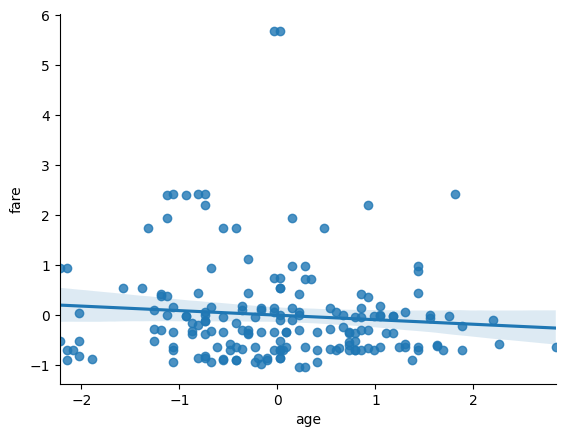

In [31]:
sns.regplot(x = "age", y = "fare", data = df_titanic_ss)
sns.despine()

In [32]:
cols = ['fare', 'age']
df_titanic_ss[cols].head()

,fare,age
1,-0.100,0.152
3,-0.338,-0.040
6,-0.355,1.176
10,-0.816,-2.023
11,-0.687,1.432


___
## **CBLOF - Cluster-based Local Outlier Factor**

In [33]:
# Normalizar as variáveis 'age' e 'fare'
df_titanic_ss = df_titanic.copy()
df_titanic_ss[['fare', 'age']] = MinMaxScaler().fit_transform(df_titanic_ss[['fare', 'age']])

In [34]:
X1 = df_titanic_ss['age'].values.reshape(-1, 1)
X2 = df_titanic_ss['fare'].values.reshape(-1, 1)
X = np.concatenate((X1,X2), axis = 1)

OUTLIERS: 2 INLIERS: 180


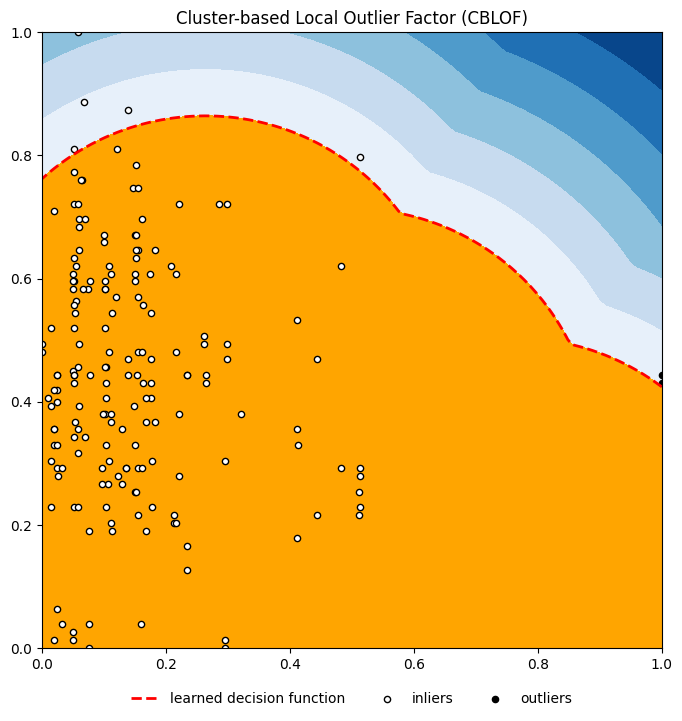

In [35]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination = outliers_fraction, check_estimator = False, random_state = 0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize = (8, 8))

df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()

inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold para definir um ponto como inlier ou outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# Calcula o Anomaly Score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 7), cmap = plt.cm.Blues_r)
        
# Desenha a linha vermelha a partir do qual Anomaly Score = thresold
a = plt.contour(xx, yy, Z, levels = [threshold], linewidths = 2, colors = 'red')
        
# Região Azul onde threshold < Anomaly Score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()], colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c = 'white', s = 20, edgecolor = 'k')
    
c = plt.scatter(outliers_fare, outliers_age, c = 'black', s = 20, edgecolor = 'k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b, c], ['learned decision function', 'inliers', 'outliers'],
           prop = matplotlib.font_manager.FontProperties(size = 10), loc = 'upper center', frameon = False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show()

In [36]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.444,0,1,1.000,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.431,0,0,1.000,C,First,man,True,B,Cherbourg,yes,True,1


In [37]:
# Zoom na linha 679
df_titanic.loc[679]

survived               1
pclass                 1
sex                 male
age               36.000
sibsp                  0
parch                  1
fare             512.329
embarked               C
class              First
who                  man
adult_male          True
deck                   B
embark_town    Cherbourg
alive                yes
alone              False
Name: 679, dtype: object

In [38]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

,age,fare
,mean,mean
sex,,
female,33.000,89.000
male,38.000,69.000


In [39]:
# Média Geral de 'age'
round(df_titanic['age'].mean())

36

In [40]:
# Média Geral de 'fare'
round(df_titanic['fare'].mean())

79


## **HBOS - Histogram-based Outlier Detection**

df_titanic_ss = df_titanic.copy()

df_titanic_ss[['fare', 'age']] = MinMaxScaler().fit_transform(df_titanic_ss[['fare', 'age']])



X1 = df_titanic_ss['age'].values.reshape(-1, 1)

X2 = df_titanic_ss['fare'].values.reshape(-1, 1)

X = np.concatenate((X1,X2), axis = 1)

In [72]:
X.shape

(442, 10)

OUTLIERS: 2 INLIERS: 180


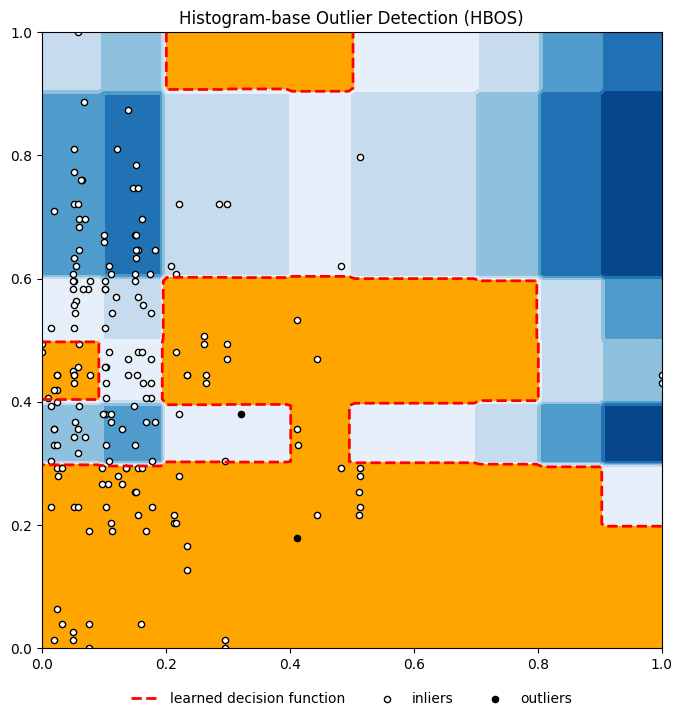

In [41]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination = outliers_fraction)
clf.fit(X)

# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))

# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()
    
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1, 1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1, 1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1, 1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1, 1)
         
print('OUTLIERS:', n_outliers, 'INLIERS:', n_inliers)
        
# threshold define se um ponto será outlier ou inlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# Calcula o Anomaly score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

# Define a região azul tal que min(Anomaly score) < threshold
plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 7), cmap = plt.cm.Blues_r)
        
# Desenha a linha a partir do queal Anomaly score = thresold
a = plt.contour(xx, yy, Z, levels = [threshold], linewidths = 2, colors = 'red')
        
# Define a região laranja a partir do qual threshold < Anomaly score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels = [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b, c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size = 10), loc ='upper center', frameon = False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

In [42]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
318,1,1,female,0.380,0,2,0.322,S,First,woman,False,C,Southampton,yes,False,1
689,1,1,female,0.178,0,1,0.413,S,First,child,False,B,Southampton,yes,False,1


In [43]:
# Zoom na linha 689
df_titanic.loc[689]

survived                 1
pclass                   1
sex                 female
age                 15.000
sibsp                    0
parch                    1
fare               211.338
embarked                 S
class                First
who                  child
adult_male           False
deck                     B
embark_town    Southampton
alive                  yes
alone                False
Name: 689, dtype: object

In [44]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

,age,fare
,mean,mean
sex,,
female,33.000,89.000
male,38.000,69.000


In [45]:
# Média Geral de 'age'
round(df_titanic['age'].mean())

36

In [46]:
# Média Geral de 'fare'
round(df_titanic['fare'].mean())

79

___
## **Isolation Forest**

OUTLIERS:  2 INLIERS:  180


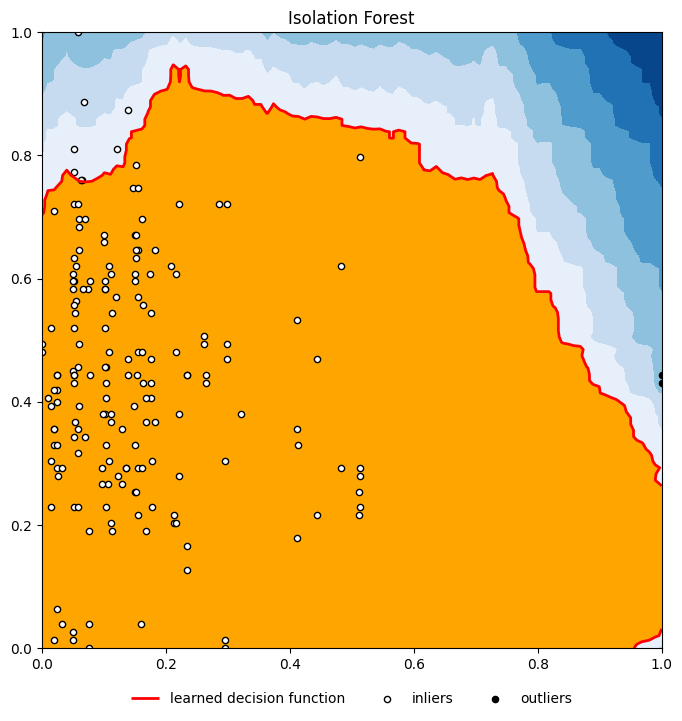

In [47]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination = outliers_fraction,random_state = 0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))
# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()
    
# fare - inlier feature 1,  age - inlier feature 2
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
# fare - outlier feature 1, age - outlier feature 2
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ', n_outliers,'INLIERS: ', n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels= [threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size = 10), loc='upper center', frameon= False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

In [48]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.444,0,1,1.000,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.431,0,0,1.000,C,First,man,True,B,Cherbourg,yes,True,1


In [49]:
# Zoom na linha 679
df_titanic.loc[679]

survived               1
pclass                 1
sex                 male
age               36.000
sibsp                  0
parch                  1
fare             512.329
embarked               C
class              First
who                  man
adult_male          True
deck                   B
embark_town    Cherbourg
alive                yes
alone              False
Name: 679, dtype: object

In [50]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

,age,fare
,mean,mean
sex,,
female,33.000,89.000
male,38.000,69.000


In [51]:
# Média Geral de 'age'
round(df_titanic['age'].mean())

36

In [52]:
# Média Geral de 'fare'
round(df_titanic['fare'].mean())

79

___
## **KNN - K-Nearest Neighbors**

OUTLIERS:  2 INLIERS:  180


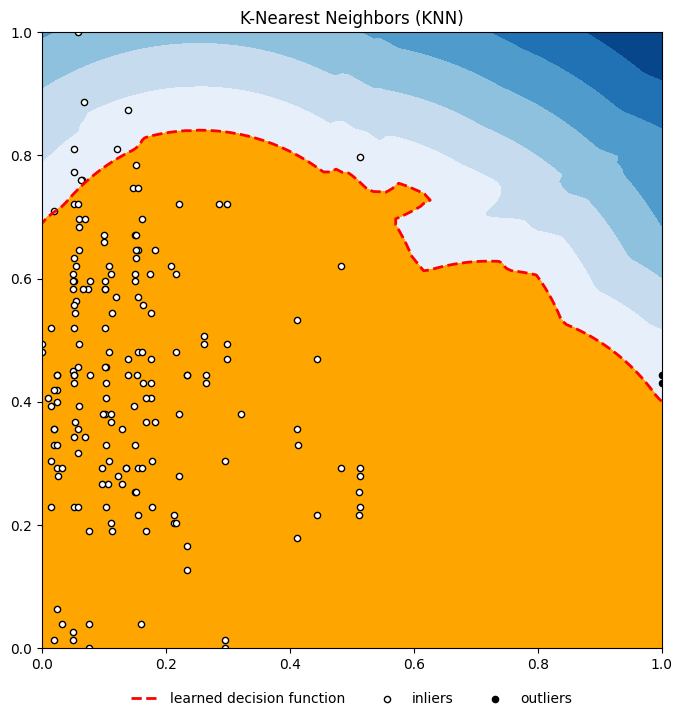

In [53]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination = outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))
# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()
    
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers, 'INLIERS: ', n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels= [threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10), loc='upper center', frameon= False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K-Nearest Neighbors (KNN)')
plt.show();

In [54]:
df1.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
1,1,1,female,0.469,1,0,0.139,C,First,woman,False,C,Cherbourg,yes,False,0
3,1,1,female,0.431,1,0,0.104,S,First,woman,False,C,Southampton,yes,False,0
6,0,1,male,0.671,0,0,0.101,S,First,man,True,E,Southampton,no,True,0
10,1,3,female,0.039,1,1,0.033,S,Third,child,False,G,Southampton,yes,False,0
11,1,1,female,0.722,0,0,0.052,S,First,woman,False,C,Southampton,yes,True,0


In [55]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.444,0,1,1.000,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.431,0,0,1.000,C,First,man,True,B,Cherbourg,yes,True,1


In [56]:
# Zoom na linha 679
df_titanic.loc[679]

survived               1
pclass                 1
sex                 male
age               36.000
sibsp                  0
parch                  1
fare             512.329
embarked               C
class              First
who                  man
adult_male          True
deck                   B
embark_town    Cherbourg
alive                yes
alone              False
Name: 679, dtype: object

In [57]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby('sex').agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

,age,fare
,mean,mean
sex,,
female,33.000,89.000
male,38.000,69.000


In [58]:
# Média Geral de 'age'
round(df_titanic['age'].mean())

36

In [59]:
# Média Geral de 'fare'
round(df_titanic['fare'].mean())

79

___
# **Exercícios**
Para cada um dos dataframes a seguir, faça uma análise de outlier utilizando uma das técnicas apresentadas e explique seus resultados.

## Exercício 1 - Predict Breast Cancer

In [60]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer['data']
y = cancer['target']

df_cancer = pd.DataFrame(np.c_[X, y], columns= np.append(cancer['feature_names'], ['target']))
df_cancer['target'] = df_cancer['target'].map({0: 'malign', 1: 'benign'})
df_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,0.242,0.079,1.095,0.905,8.589,153.400,0.006,0.049,0.054,0.016,0.030,0.006,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119,malign
1,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,0.057,0.543,0.734,3.398,74.080,0.005,0.013,0.019,0.013,0.014,0.004,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089,malign
2,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.030,0.006,0.040,0.038,0.021,0.022,0.005,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088,malign
3,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,0.097,0.496,1.156,3.445,27.230,0.009,0.075,0.057,0.019,0.060,0.009,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173,malign
4,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.440,0.011,0.025,0.057,0.019,0.018,0.005,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077,malign


## Exercício 2 - Boston Housing Price

In [61]:
from sklearn.datasets import load_boston

boston = load_boston()
X = boston['data']
y = boston['target']

df_boston = pd.DataFrame(np.c_[X, y], columns = np.append(boston['feature_names'], ['target']))
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.006,18.000,2.310,0.000,0.538,6.575,65.200,4.090,1.000,296.000,15.300,396.900,4.980,24.000
1,0.027,0.000,7.070,0.000,0.469,6.421,78.900,4.967,2.000,242.000,17.800,396.900,9.140,21.600
2,0.027,0.000,7.070,0.000,0.469,7.185,61.100,4.967,2.000,242.000,17.800,392.830,4.030,34.700
3,0.032,0.000,2.180,0.000,0.458,6.998,45.800,6.062,3.000,222.000,18.700,394.630,2.940,33.400
4,0.069,0.000,2.180,0.000,0.458,7.147,54.200,6.062,3.000,222.000,18.700,396.900,5.330,36.200


## Exercício 3 - Iris
* [Aqui](https://en.wikipedia.org/wiki/Iris_flower_data_set) você obterá mais informações sobre o dataframe iris.

In [62]:
from sklearn.datasets import load_iris

iris = load_iris()
X= iris['data']
y= iris['target']

df_iris = pd.DataFrame(np.c_[X, y], columns = np.append(iris['feature_names'], ['target']))
df_iris['target'] = df_iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


## Exercícios 4 - Diabetes

In [63]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = diabetes['data']
y = diabetes['target']

df_diabetes = pd.DataFrame(np.c_[X, y], columns = np.append(diabetes['feature_names'], ['target']))
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038,0.051,0.062,0.022,-0.044,-0.035,-0.043,-0.003,0.020,-0.018,151.000
1,-0.002,-0.045,-0.051,-0.026,-0.008,-0.019,0.074,-0.039,-0.068,-0.092,75.000
2,0.085,0.051,0.044,-0.006,-0.046,-0.034,-0.032,-0.003,0.003,-0.026,141.000
3,-0.089,-0.045,-0.012,-0.037,0.012,0.025,-0.036,0.034,0.023,-0.009,206.000
4,0.005,-0.045,-0.036,0.022,0.004,0.016,0.008,-0.003,-0.032,-0.047,135.000
